In [1]:
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('Agg');
import matplotlib.pyplot as plt
plt.set_cmap('jet');
%matplotlib inline

In [2]:
import medpy # need to pip install itk as well
import medpy.io

In [3]:
p='/data/lisa/data/BRATS2013/Synthetic_Data/HG/0001/VSD.Brain.XX.O.MR_Flair/VSD.Brain.XX.O.MR_Flair.865_N4ITK.mha'
image_data, image_header = medpy.io.load(p)

In [4]:
image_data = image_data.T

In [5]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets

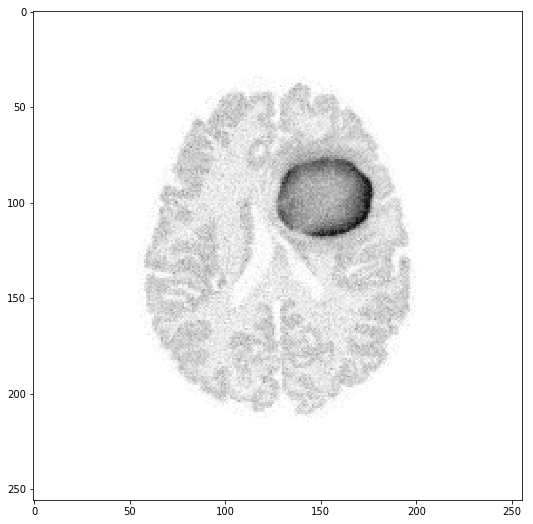

In [6]:
plt.rcParams['figure.figsize'] = (10, 9)
x_widget = ipywidgets.FloatSlider(min=0.0, max=image_data.shape[0], step=1);
interact(lambda(x): plt.imshow(image_data[int(x)], cmap='Greys'),x=x_widget);

In [17]:
basepath = "/data/lisa/data/BRATS2013"
import glob, os
import re

def get_data(glob_pattern):
    data = {}
    for filename in glob.iglob(glob_pattern):
        print ".",
        path = os.path.normpath(filename).split(os.sep)
        number = list(reversed(path))[2]
        level = list(reversed(path))[3]
        name = level+number
        #print name
        image_data, image_header = medpy.io.load(filename)
        image_data = image_data.T
        image_data = np.round(image_data) #maybe not the best?
        image_data = image_data.astype(np.uint16)
        data[name] = image_data
    return data


flair = get_data(basepath + "/Synthetic_Data/*/*/*/*Flair.*N4ITK.mha")
t1 = get_data(basepath + "/Synthetic_Data/*/*/*/*T1.*N4ITK.mha")
t1c = get_data(basepath + "/Synthetic_Data/*/*/*/*T1c.*N4ITK.mha")
t2 = get_data(basepath + "/Synthetic_Data/*/*/*/*T2.*N4ITK.mha")
labels = get_data(basepath + "/Synthetic_Data/*/*/*/*5more*N4ITK.mha")

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


In [18]:
labels['LG0001'].shape

(181, 256, 256)

In [19]:
def get_labels(rightside):
    met = {}
    met["brain"]    = (1.*(rightside!= 0).sum()/(rightside == 0).sum())
    met["tumor"]    = (1.*(rightside > 2).sum()/((rightside != 0).sum() + 1e-10))
    met["necrosis"] = (1.*(rightside > 3).sum()/((rightside != 0).sum() + 1e-10))
    
    met["has_enough_brain"] = met["brain"]     > 0.30
    met["has_tumor"]        = met["tumor"]     > 0.1
    met["has_necrosis"]     = met["necrosis"]  > 0.05
    return met
    
    

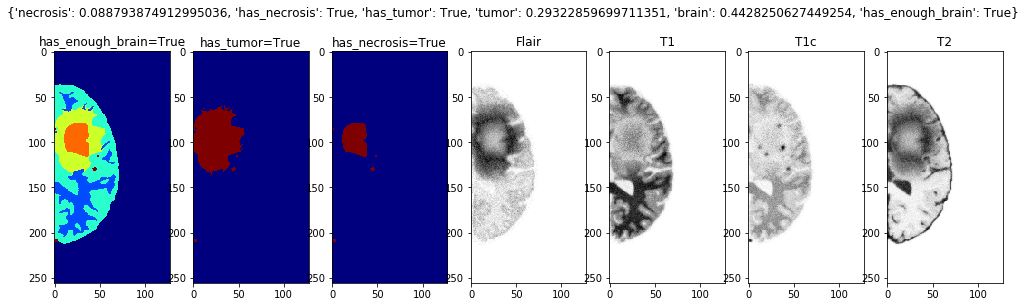

In [60]:
sample = 'LG0001'
slide = 89
label = labels[sample][slide][:,128:]
fla = flair[sample][slide][:,128:]
it1 = t1[sample][slide][:,128:]
it1c = t1c[sample][slide][:,128:]
it2 = t2[sample][slide][:,128:]

met = get_labels(label)

plt.rcParams['figure.figsize'] = (17, 9)
fig, axarr = plt.subplots(1,7);
axarr[0].imshow(label);
axarr[0].set_title("has_enough_brain="+ str(met["has_enough_brain"]))
axarr[1].imshow(label > 2);
axarr[1].set_title("has_tumor="+ str(met["has_tumor"]))
axarr[2].imshow(label > 3);
axarr[2].set_title("has_necrosis="+ str(met["has_necrosis"]))
axarr[3].imshow(fla, cmap='Greys');
axarr[3].set_title("Flair")
axarr[4].imshow(it1, cmap='Greys');
axarr[4].set_title("T1")
axarr[5].imshow(it1c, cmap='Greys');
axarr[5].set_title("T1c")
axarr[6].imshow(it2, cmap='Greys');
axarr[6].set_title("T2")

fig.suptitle(met, y=0.75);

In [23]:
# now create a dataframe and compute the label values

In [24]:
dataset = []
for sample in labels.keys():
    for slide in range(labels[sample].shape[0]):
        rightside = labels[sample][slide][:,128:]
        met = get_labels(rightside)
        met["sample"] = sample
        met["slide"] = slide
        dataset.append(met)
        #if met["has_enough_brain"]:
        met["flair"] = flair[sample][slide][:,128:]
        met["t1"] = t1[sample][slide][:,128:]

In [25]:
stats = pd.DataFrame(dataset)

In [26]:
stats[stats.has_enough_brain].head()

,brain,flair,has_enough_brain,has_necrosis,has_tumor,necrosis,sample,slide,t1,tumor
47,0.306904,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",True,False,True,0.021442,HG0018,47,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.269396
48,0.314611,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",True,False,True,0.019638,HG0018,48,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.253889
49,0.321503,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",True,False,True,0.018941,HG0018,49,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.246362
50,0.328630,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",True,False,True,0.019741,HG0018,50,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.239605
51,0.338179,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",True,False,True,0.018476,HG0018,51,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.234513


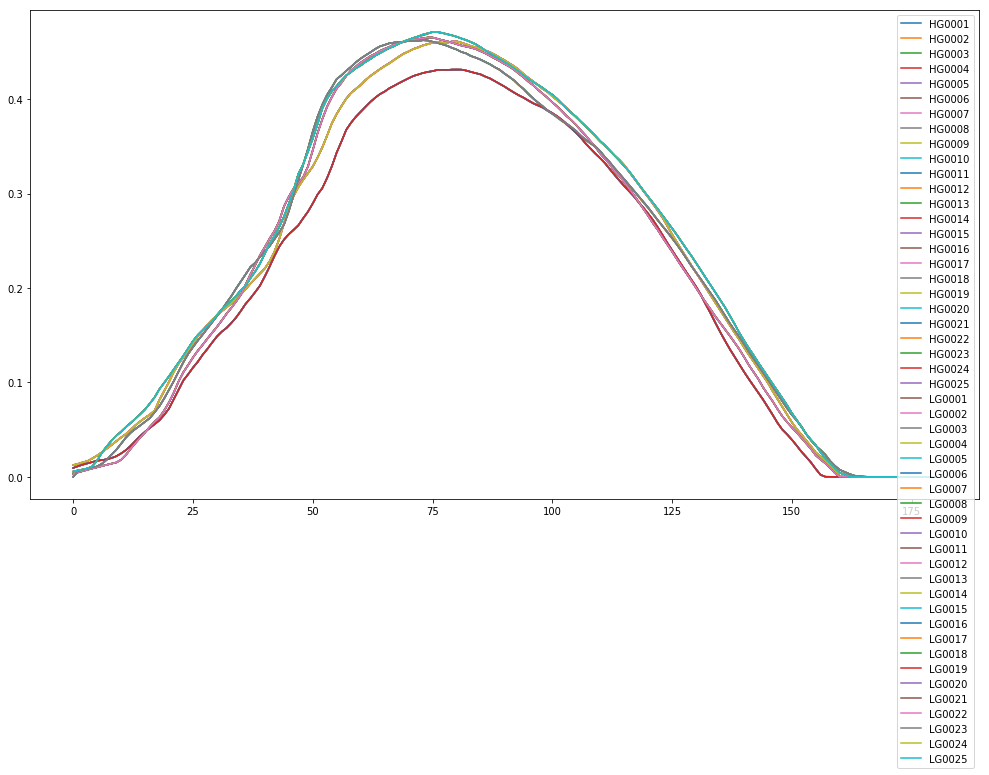

In [27]:
for sample in np.sort(stats["sample"].unique()):
    plt.plot(stats[stats["sample"]==sample].slide, stats[stats["sample"]==sample].brain, label=sample);
plt.legend();

In [16]:
#build dataset
#stratify on two variables

In [28]:
#base = stats[stats.has_enough_brain][["sample", "slide", "has_tumor", "has_necrosis"]]
base = stats[stats.has_enough_brain]
base.shape

(3540, 10)

In [29]:
import collections
print "tumor", collections.Counter(base.has_tumor)
print "necrosis", collections.Counter(base.has_necrosis)

tumor Counter({False: 1811, True: 1729})
necrosis Counter({False: 2982, True: 558})


In [30]:
import sklearn, sklearn.model_selection
domaina, domainb = sklearn.model_selection.train_test_split(base, stratify=zip(base.has_tumor,base.has_necrosis),test_size=0.5, random_state=42)

In [20]:
#np.savez(open("domaina.npz", "w"), np.asarray(list(domaina.flair.as_matrix())))

In [21]:
#np.savez(open("domainb.npz", "w"), np.asarray(list(domainb.t1.as_matrix())))

In [ ]:
if not os.path.exists("cyclegan/datasets/brats2013"):
    os.makedirs("cyclegan/datasets/brats2013/trainA")
    os.makedirs("cyclegan/datasets/brats2013/trainB")

In [56]:
import skimage
from skimage.io import imread, imsave

for i, row in domaina.iterrows():
    img = row.flair
    imgg = 1.*img/img.max()
    name = str(row["sample"]) + "-" + str(row.slide) + "-" + str(row.has_tumor) + "-" + str(row.has_necrosis)
    imsave("cyclegan/datasets/brats2013/trainA/" + name + ".png", imgg)
    
for i, row in domainb.iterrows():
    img = row.t1
    imgg = 1.*img/img.max()
    name = str(row["sample"]) + "-" + str(row.slide) + "-" + str(row.has_tumor) + "-" + str(row.has_necrosis)
    imsave("cyclegan/datasets/brats2013/trainB/" + name + ".png", imgg)